# Imports

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import gym
import time
from e2 import CacheEnv

import random
import matplotlib.pyplot as plt
import matplotlib
from collections import namedtuple
from itertools import count
from PIL import Image

import torch.optim as optim
import math
import torchvision.transforms as T

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display
plt.ion()    

Using device: cuda


In [2]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [3]:
class Net(nn.Module):
    def __init__(self, ):
        super(Net, self).__init__()
        input_size = N_STATES
        h_dim = 50
#         h_dim = 30
        self.fc1 = nn.Linear(input_size, h_dim)
        self.fc2 = nn.Linear(h_dim, h_dim//4)
        self.fc3 = nn.Linear(h_dim//4, h_dim)
        self.out = nn.Linear(h_dim, n_actions)

    def forward(self, x):
#         bs = x.shape[0]
        if len(x.shape) == 1:
            x = x.view(-1, x.size(0))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.out(x)
        return x

In [4]:
BATCH_SIZE = 128
GAMMA = 0.999
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 200
# TARGET_UPDATE = 10
TARGET_UPDATE = 200

# EPS_LEN = 100
EPS_LEN = 200
N_PAGES = 10
CACHE_LIMIT = 5 
STATE_SHAPE = (CACHE_LIMIT, 2)
N_STATES = STATE_SHAPE[0]*STATE_SHAPE[1]

env = CacheEnv(
        eps_len=EPS_LEN, 
        n_pages=N_PAGES, 
        limit=CACHE_LIMIT
        )


# Get number of actions from gym action space
n_actions = env.action_space_n

policy_net =  Net().to(device)
target_net = Net().to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

# optimizer = optim.RMSprop(policy_net.parameters())
optimizer = optim.Adam(policy_net.parameters(), 3e-3)
memory = ReplayMemory(10000)


steps_done = 0


def select_action(state):
#     state = torch.Tensor(state).to(device)
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1) will return largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
#             out = policy_net(state)
#             print(out)
#             print(out.shape)
#             return out.max()[1].view(1, 1)
            return policy_net(state).max(1)[1].view(1, 1)
    else:
        return torch.tensor([[random.randrange(n_actions)]], device=device, dtype=torch.long)


episode_durations = []


def plot_durations():
    plt.figure(2)
    plt.clf()
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        display.clear_output(wait=True)
        display.display(plt.gcf())

Cache limit: 5
Total Pages: 10


In [5]:
batch = None
def optimize_model():
    global batch
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None]).view(-1, CACHE_LIMIT*2)
#     state_batch = torch.cat(batch.state)
    state_batch = torch.cat(batch.state).view(-1, CACHE_LIMIT*2)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1)[0].
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()

In [11]:
num_episodes = 5000

history = []
for i_episode in range(num_episodes):
    # Initialize the environment and state
    state = env.reset()
    state = torch.Tensor(state).to(device)
    ep_r = 0
    actions = []
    for t in count():
        # Select and perform an action
        action = select_action(state)
        actions.append(action.cpu().numpy()[0])
#         print(f"Selection action: {action}")
        state_, reward, done, _ = env.step(action.item())
        state_ = torch.Tensor(state_).to(device)
        reward = torch.tensor([reward], device=device)
        ep_r += reward

        # Observe new state

        if not done:
            next_state = state_ 
        else:
            next_state = None

        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the target network)
        optimize_model()
        if done:
            episode_durations.append(t + 1)
            epr = ep_r.cpu().numpy()[0]
            history.append(epr)
            (values,counts) = np.unique(np.array(actions), return_counts=True)
            ind=np.argmax(counts)
            counts.sort()
            if i_episode%50 == 0:
                print(f"Ep: {i_episode} | Reward: {epr} | Most common action: {values[ind]} | Top freq: {counts[::-1][:10]}")
            
#             plot_durations()
            break
    # Update the target network, copying all weights and biases in DQN
    if i_episode % TARGET_UPDATE == 0:
        target_net.load_state_dict(policy_net.state_dict())

print('Complete')
env.render()
env.close()
plt.ioff()
plt.show()


Ep: 0 | Reward: 192 | Most common action: 0 | Top freq: [80 43 40 36  1]
Ep: 50 | Reward: 380 | Most common action: 2 | Top freq: [75 58 46 16  5]
Ep: 100 | Reward: 372 | Most common action: 2 | Top freq: [157  19  16   6   2]
Ep: 150 | Reward: 285 | Most common action: 2 | Top freq: [77 48 36 35  4]
Ep: 200 | Reward: 358 | Most common action: 0 | Top freq: [103  59  15  15   8]
Ep: 250 | Reward: 372 | Most common action: 0 | Top freq: [119  37  22  19   3]
Ep: 300 | Reward: 295 | Most common action: 2 | Top freq: [90 40 37 21 12]
Ep: 350 | Reward: 359 | Most common action: 2 | Top freq: [84 76 16 15  9]
Ep: 400 | Reward: 335 | Most common action: 2 | Top freq: [74 50 42 22 12]
Ep: 450 | Reward: 305 | Most common action: 2 | Top freq: [125  37  26  11   1]
Ep: 500 | Reward: 336 | Most common action: 2 | Top freq: [95 74 16 10  5]
Ep: 550 | Reward: 331 | Most common action: 2 | Top freq: [57 44 44 33 22]
Ep: 600 | Reward: 302 | Most common action: 2 | Top freq: [121  44  13  12  10]
Ep:

KeyboardInterrupt: 

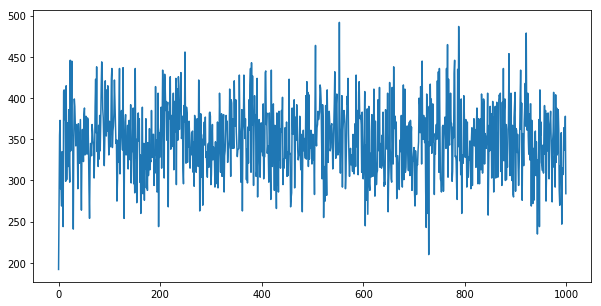

In [15]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(history[:1000])
# plt.plot(history)
plt.show()

# Debug

In [ ]:
# def pretty_print(s):
#     for i, x in enumerate(s):
#         if i == len(s)-1:
#             end = '\n'
#         elif i%2 == 0:
#             end = '-'
#         else:
#             end = ', ' 
#         print(x, end=end)

3

# Compare with others

In [21]:
from tqdm import tqdm_notebook as tqdm

def choose_action(s, agent):
    if agent == 'dqn':
        return select_action(torch.Tensor(s).to(device)) 
    if agent == 'lru':
        return s[::2].argmin()
    if agent == 'random':
        return np.random.randint(n_actions)
    else:
        return s[1::2].argmin()
    
    
ntests = 1000
performance = {}

for agent in "dqn random lru lfu".split():
    for i in tqdm(range(ntests)):
        s = env.reset()
        nhits = 0
        while True:
            a = choose_action(s, agent)
            s_, r, done, info = env.step(a)
            nhits += r

            if done:
                history.append(nhits)
                break
            s = s_
    performance[agent] = np.array(history).mean()      


In [22]:
performance

{'dqn': 353.2079207920792,
 'random': 348.7354368932039,
 'lru': 336.1838721528288,
 'lfu': 344.3589333781965}